# Import packages

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import random, re, math
from tensorflow import keras
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras import layers
from sklearn.model_selection import KFold

# Detect TPU and specify file paths

In [2]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

# In order to train on TPU we need to store in Google Cloud Storage
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [192, 192] 
GCS_PATH_SELECT = { 
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') #Training dataset
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec') #Validation dataset
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') #Test dataset

# Set Batch Size
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

Running on TPU  grpc://10.0.0.2:8470


# Define Helper Functions
(Courtesy: Petal Helper)

In [3]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum 

def load_dataset(filenames, labeled = True, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        
    #automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    
    #uses data as soon as it streams in instead of original order
    dataset = dataset.with_options(ignore_order)
    
    #returns (image, label) if labeled == True else(image, id)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    
    return dataset

def data_augment(image, label):

    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset,do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 

# Scripts for Data Augmentation 
(Courtesy: Chris Deotte)

In [4]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

# Compute the number of examples in each dataset and number of output classes

In [5]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Load datasets

In [6]:
train_dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
valid_dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=True)
test_dataset = get_test_dataset(ordered=True)
print('Loaded Datasets....')

Loaded Datasets....


# Import pre-trained Network 

In [7]:
from tensorflow.keras.applications import ResNet50, Xception, DenseNet201 #change here if you want to change the network
from tensorflow.keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

# Customize the Neural Networks for this competition

In [8]:
def build_xception_network():
    with strategy.scope():
        #change the class if you want to change the network
        network = Xception(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),weights='imagenet',include_top=False)
        network.trainable = True
        model = Sequential([network, GlobalAveragePooling2D(), Dense(len(CLASSES), activation = 'softmax', dtype = 'float32')])
        
        opt = 'Adam'
        model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
        return model
    
def build_resnet_network():
    with strategy.scope():
        #change the class if you want to change the network
        network = ResNet50(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),weights='imagenet',include_top=False)
        network.trainable = True
        model = Sequential([network, GlobalAveragePooling2D(), Dense(len(CLASSES), activation = 'softmax', dtype = 'float32')])
        
        opt = 'Adam'
        model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
        return model
    
def build_densenet_network():
    with strategy.scope():
        #change the class if you want to change the network
        network = DenseNet201(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),weights='imagenet',include_top=False)
        network.trainable = True
        model = Sequential([network, GlobalAveragePooling2D(), Dense(len(CLASSES), activation = 'softmax', dtype = 'float32')])
        
        opt = 'Adam'
        model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
        return model

# Setup for training the Deep Neural Network

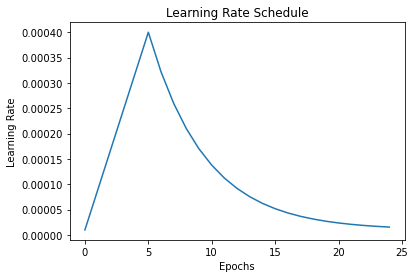

In [9]:
EPOCHS = 15
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
SEED = 7

# Define a customized learning rate schedule
def scheduler(epoch, lr):
    lr_start = 0.00001
    lr_min = 0.00001
    lr_max = 0.00005 * strategy.num_replicas_in_sync
    lr_rampup_epochs = 5
    lr_sustain_epochs = 0
    lr_exp_decay = .8
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

#example plot for learning rate
epoch_range = [i for i in range(25)]
lr_schedule = [scheduler(epoch, 0) for epoch in epoch_range] #the second arg in scheduler doesn't matter
plt.plot(epoch_range, lr_schedule)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

#Add learning rate scheduler to callback list
lr_schedule = LearningRateScheduler(scheduler)
callback_list = [lr_schedule]

def train(num):
    if num == 1:
        print('Training Xception....')
        model = build_xception_network()
        history = model.fit(get_training_dataset(train_dataset), validation_data = get_validation_dataset(valid_dataset), epochs = EPOCHS, batch_size = BATCH_SIZE,steps_per_epoch = STEPS_PER_EPOCH, callbacks = callback_list)
        print('Training completed....')
    elif num == 2:
        print('Training ResNet50....')
        model = build_resnet_network()
        history = model.fit(get_training_dataset(train_dataset), validation_data = get_validation_dataset(valid_dataset), epochs = EPOCHS, batch_size = BATCH_SIZE,steps_per_epoch = STEPS_PER_EPOCH, callbacks = callback_list)
        print('Training completed....')
    elif num == 3:
        print('Training DenseNet201....')
        model = build_densenet_network()
        history = model.fit(get_training_dataset(train_dataset), validation_data = get_validation_dataset(valid_dataset), epochs = EPOCHS, batch_size = BATCH_SIZE,steps_per_epoch = STEPS_PER_EPOCH, callbacks = callback_list)
        print('Training completed....')
    else:
        raise Exception('Add Network')
    
    return history, model
   
def plot_train_and_val_stats(history):
    
    # Plots training and validation losses
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['train loss', 'validation loss'], loc='upper left')
    plt.show()
        
    #Plots training and validation accuracy
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train accuracy', 'validation accuracy'], loc='upper left')
    plt.show()
    return 
    

# Train and predict

Training Xception....
83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/15
99/99 [==============================] - 21s 211ms/step - loss: 4.5101 - sparse_categorical_accuracy: 0.0636 - val_loss: 4.2057 - val_sparse_categorical_accuracy: 0.1263 - lr: 1.0000e-05
Epoch 2/15
99/99 [==============================] - 9s 87ms/step - loss: 2.9205 - sparse_categorical_accuracy: 0.3814 - val_loss: 1.7259 - val_sparse_categorical_accuracy: 0.5927 - lr: 8.8000e-05
Epoch 3/15
99/99 [==============================] - 9s 87ms/step - loss: 1.3342 - sparse_categorical_accuracy: 0.6942 - val_loss: 0.8349 - val_sparse_categorical_accuracy: 0.7912 - lr: 1.6600e-04
Epoch 4/15
99/99 [==============================] - 9s 87ms/step - loss: 0.7147 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.5867 - val_sparse_categorical_accuracy: 0.8543 - lr: 2.4400e-04
Epoch 5/15
99/99 [==============================] - 8s 86ms/step - loss: 0.4713 - sparse_categorical_accuracy: 0.8801 - val_los

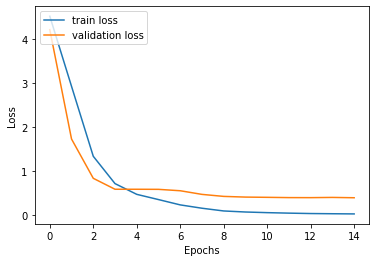

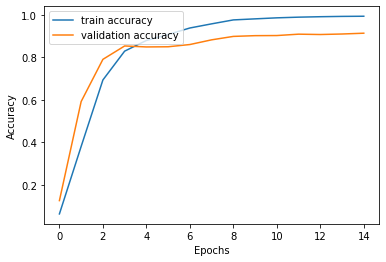

Training ResNet50....
94773248/94765736 [==============================] - 2s 0us/step
Epoch 1/15
99/99 [==============================] - 19s 188ms/step - loss: 4.2356 - sparse_categorical_accuracy: 0.1197 - val_loss: 5.1175 - val_sparse_categorical_accuracy: 0.0391 - lr: 1.0000e-05
Epoch 2/15
99/99 [==============================] - 9s 93ms/step - loss: 1.9137 - sparse_categorical_accuracy: 0.5586 - val_loss: 5.8324 - val_sparse_categorical_accuracy: 0.0331 - lr: 8.8000e-05
Epoch 3/15
99/99 [==============================] - 9s 92ms/step - loss: 0.8721 - sparse_categorical_accuracy: 0.7745 - val_loss: 5.9741 - val_sparse_categorical_accuracy: 0.0442 - lr: 1.6600e-04
Epoch 4/15
99/99 [==============================] - 9s 93ms/step - loss: 0.6053 - sparse_categorical_accuracy: 0.8360 - val_loss: 5.1677 - val_sparse_categorical_accuracy: 0.0369 - lr: 2.4400e-04
Epoch 5/15
99/99 [==============================] - 9s 94ms/step - loss: 0.5241 - sparse_categorical_accuracy: 0.8554 - val_los

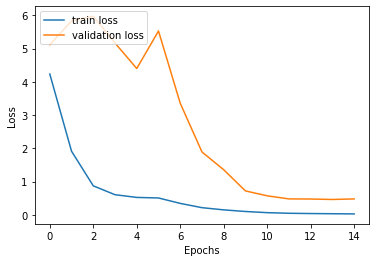

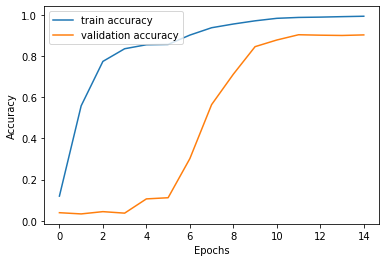

Training DenseNet201....
74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/15
99/99 [==============================] - 43s 430ms/step - loss: 4.4053 - sparse_categorical_accuracy: 0.0791 - val_loss: 3.8270 - val_sparse_categorical_accuracy: 0.2085 - lr: 1.0000e-05
Epoch 2/15
99/99 [==============================] - 19s 192ms/step - loss: 1.9516 - sparse_categorical_accuracy: 0.5805 - val_loss: 1.0149 - val_sparse_categorical_accuracy: 0.7540 - lr: 8.8000e-05
Epoch 3/15
99/99 [==============================] - 19s 192ms/step - loss: 0.8075 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.6166 - val_sparse_categorical_accuracy: 0.8548 - lr: 1.6600e-04
Epoch 4/15
99/99 [==============================] - 19s 192ms/step - loss: 0.4715 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.6213 - val_sparse_categorical_accuracy: 0.8494 - lr: 2.4400e-04
Epoch 5/15
99/99 [==============================] - 19s 193ms/step - loss: 0.3684 - sparse_categorical_accuracy: 0.910

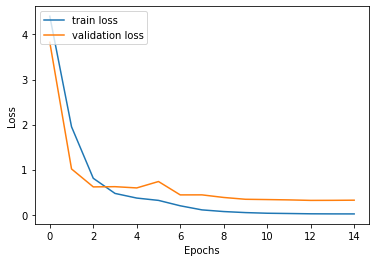

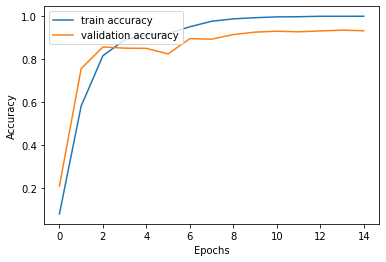

In [10]:
history_xception, model_xception = train(1)
plot_train_and_val_stats(history_xception)

history_resnet, model_resnet = train(2)
plot_train_and_val_stats(history_resnet)

history_densenet, model_densenet = train(3)
plot_train_and_val_stats(history_densenet)

In [11]:

print('Computing predictions....')
test_images_ds = test_dataset.map(lambda image, idnum: image)
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')   
probabilities = 0.25*model_resnet.predict(test_images_ds)+0.25*model_xception.predict(test_images_ds)+0.5*model_densenet.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
    
print('Compiling submission file...')
np.savetxt('submission.csv',np.rec.fromarrays([test_ids, predictions]),fmt=['%s', '%d'],delimiter=',',header='id,label',comments='')

Computing predictions....
Compiling submission file...


# Generate Confusion Matrix (individually and weighted model)
Courtesy: Petal Helper & Chris Deotte

In [12]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    


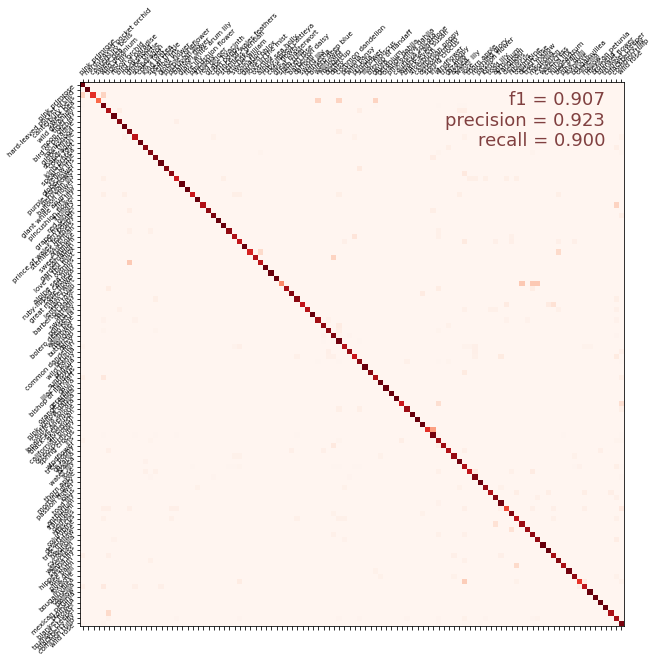

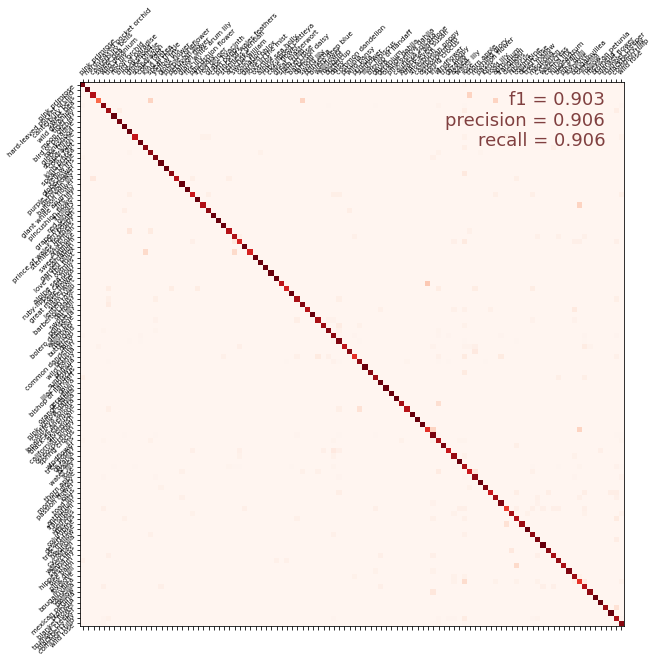

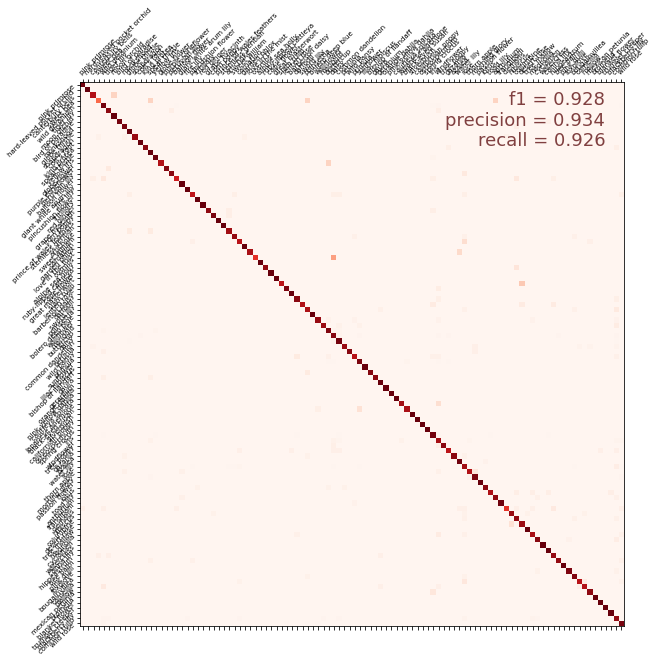

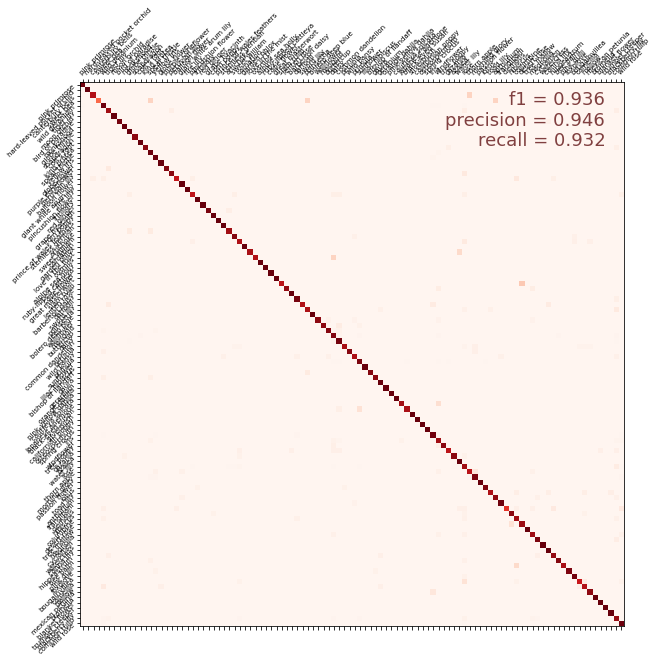

In [13]:
#Import relevant packages from SkLearn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

cmdataset = get_validation_dataset(load_dataset(VALIDATION_FILENAMES, labeled = True, ordered = True)) 
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

# Compute and display goodness of fit of Xception 
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
cm_probabilities = model_xception.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

cmat_1 = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score_1 = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision_1 = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall_1 = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat_1 = (cmat_1.T / cmat_1.sum(axis=1)).T 
display_confusion_matrix(cmat_1, score_1, precision_1, recall_1)

# Compute and display goodness of fit of ResNet50
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
cm_probabilities = model_resnet.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

cmat_2 = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score_2 = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision_2 = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall_2 = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat_2 = (cmat_2.T / cmat_2.sum(axis=1)).T 
display_confusion_matrix(cmat_2, score_2, precision_2, recall_2)

# Compute and display goodness of fit of DenseNet201 
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
cm_probabilities = model_densenet.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

cmat_3 = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score_3 = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision_3 = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall_3 = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat_3 = (cmat_3.T / cmat_3.sum(axis=1)).T 
display_confusion_matrix(cmat_3, score_3, precision_3, recall_3)


# Compute and display goodness of fit of the weighted model
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
cm_probabilities = 0.25*model_resnet.predict(images_ds)+0.25*model_xception.predict(images_ds)+0.5*model_densenet.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T 
display_confusion_matrix(cmat, score, precision, recall)
